In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# used for image processing
from scipy import misc

from IPython.display import Image

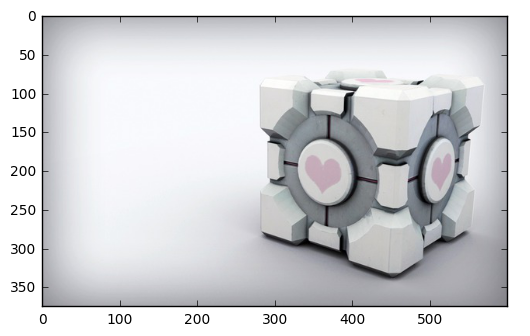

In [19]:
# get the image that we'll be using
img = mpimg.imread('Portal_Companion_Cube.jpg')

# here we'll just display it in its original form
plt.imshow(img)
plt.show()

### Simple Algorithm to convert a colored image to grayscale

The basic formula is simple Gray = (Red + Green + Blue) / 3.

In order to humanize this more we will weight the colors based on human perception of color. The new algorithm is Gray = (R \* .299 + G \* .587 + B \* .114).

In [47]:
def weighted_average(pixel):
    return 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]

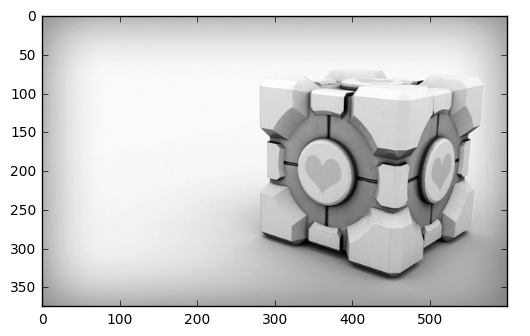

In [108]:
# now lets convert the image to grayscale

# first create an array of the same size as the image
# shape[0] is the rows and shape[1] is the columns
grey_img = np.zeros((img.shape[0], img.shape[1])) 
for row in range(img.shape[0]):
    for col in range(img.shape[1]):
        grey_img[row][col] = weighted_average(img[row][col])

## and lets see how we did
plt.imshow(grey_img, cmap=plt.cm.gray)
plt.show()

#### Simple Naive Dithering

Now that we have a gray scale image we can use a naive dithering algorithm to try and convert it to a black and white image. At each pixel the algorithm will determine whether or not to make the pixel black or white by simply checking whether the pixel is closer to 255 or 0. (Note that black is represented by 0 in grayscale and white is represented by 255). If the algorithm comes across a pixel that has the value 85. The algorithm will choose to give that pixel a value of 0. In order to compensate for this loss of whiteness in that area, the algorithm will assign an error of +85 to the next pixel. Therefore if the next pixel is also 85, the next pixel will be given a value of 170 once the error is added to it, and the next pixel will become white. Because the pixel has been rounded up by 85 to 255, the next pixel will have an error of -85, and so on. By spreading error in this naive way we can avoid blocks of black or white pixels forming across the image.

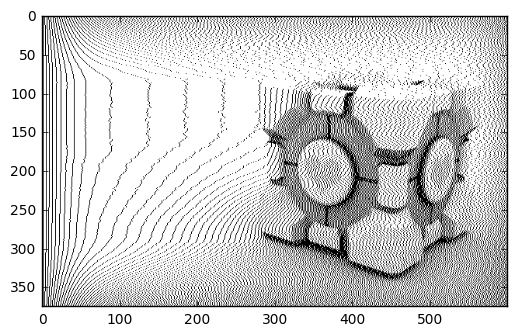

In [109]:
# now lets implement the naive dither.

# first we'll define a function that will round a number up
# to 255 or down to 0 and return the error to be used in
# the next image
def round_and_error(byte):
    if byte < 255/2:
        return 0, byte
    return 255, -255 + byte


# first create an array of the same size as the image
# shape[0] is the rows and shape[1] is the columns
naive_dither_img = np.zeros((grey_img.shape[0], grey_img.shape[1]))
# then iterate through all the rows
for row in range(grey_img.shape[0]):
    # reset the error to zero at the beginning of each row
    error = 0
    for col in range(grey_img.shape[1]):
        # save the rounded number, and the error to be used for the next pixel
        naive_dither_img[row][col], error = round_and_error(grey_img[row][col] + error)

## and lets see how we did
plt.imshow(naive_dither_img, cmap=plt.cm.gray)
plt.show()

As you can see this is not a very good result. The problem is that our algorithm implements one dimensional dithering. We only ever push errors to the right. Thus large patches of similar coloring in the original image are represented as vertical stripes in the new image. We can fix this problem by moving to using two dimensional dithering.

#### Two dimensional dithering

There have been a lot of people who have tackled the two dimensional dithering problem. But almost all two dimensional dithering follows the same pattern. Errors are pushed forward rather than backward to avoid infinite loops. Since most images are processed left to right then top to bottom, errors are always ever pushed down or to the right. Arguably the most famous dithering algorithm is Floyd-Steinberg dithering. This can be represented as the following array where X is the current pixel and the amount by which the error is divided is represented below.

        X   7
    3   5   1

     (1/16)
     
When we have an error of 85 in the current pixel. We spread the error around the surrounding pixels by multiplying and dividing 85 properly.

             X        +37.1
    +15.9    +26.5    +5.3
    
Implementing this algorithm is fairly simple. 

In [110]:
"""
Pseudocode from wikipedia

for each y from top to bottom
   for each x from left to right
      oldpixel  := pixel[x][y]
      newpixel  := find_closest_palette_color(oldpixel)
      pixel[x][y]  := newpixel
      quant_error  := oldpixel - newpixel
      pixel[x + 1][y    ] := pixel[x + 1][y    ] + quant_error * 7 / 16
      pixel[x - 1][y + 1] := pixel[x - 1][y + 1] + quant_error * 3 / 16
      pixel[x    ][y + 1] := pixel[x    ][y + 1] + quant_error * 5 / 16
      pixel[x + 1][y + 1] := pixel[x + 1][y + 1] + quant_error * 1 / 16
"""

def floyd_steinberg_dither(image):
    # first create a copy of the image since the image will be manipulated
    image_copy = np.copy(image)
    
    
    # then instantiate an array with the proper size
    fs_dither = np.zeros((image_copy.shape[0], image_copy.shape[1]))
    # iterate through the rows and columns
    for row in range(image_copy.shape[0]):
        for col in range(image_copy.shape[1]):
            oldpixel = image_copy[row][col]
            # set the new pixel to 0 if its less than 255/2 otherwise 255
            newpixel = 0 if oldpixel < 255/2 else 255
            fs_dither[row][col] = newpixel
            # calculate the error which will be dispered using the floyd steinberg matrix
            quant_error = oldpixel - newpixel
            # disperse the error correctly
            if col < image_copy.shape[1] - 1:
                image_copy[row][col + 1] = image_copy[row][col + 1] + quant_error * 7 / 16
            if col > 0 and row < image_copy.shape[0] - 1:
                image_copy[row + 1][col - 1] = image_copy[row + 1][col - 1] + quant_error * 3 / 16
            if row < grey_img.shape[0] - 1:
                image_copy[row + 1][col] = image_copy[row + 1][col] + quant_error * 5 / 16
            if row < grey_img.shape[0] - 1 and col < grey_img.shape[1] - 1:
                image_copy[row + 1][col + 1] = image_copy[row + 1][col + 1] + quant_error * 1 / 16

    return fs_dither

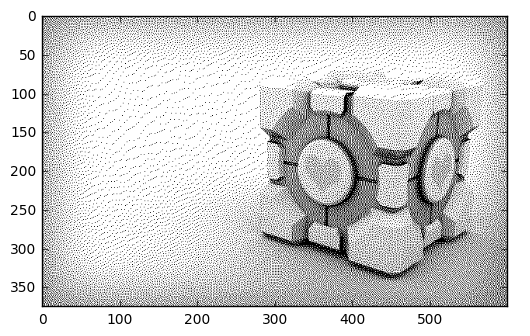

In [111]:
# Lets see how we did by dithering our gray scale image

fs_dither_img = floyd_steinberg_dither(grey_img)
plt.imshow(fs_dither_img, cmap=plt.cm.gray)
plt.show()

#### Some intuition behind the Floyd Steinberg algorithm

The floyd steinberg algorithm produces a much more evenly dispersed range of dots than the naive implementation we tried before. The reason for this can be seen when the floyd steinberg algorithm is applied to a solid gray image. Lets try it out below!

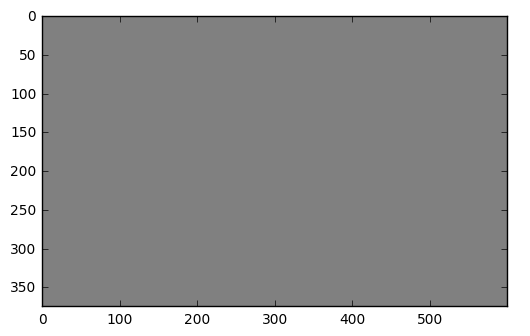

In [115]:
# We'll start by creating a solid gray image

solid_gray_img = np.full((grey_img.shape[0], grey_img.shape[1]), 255/2)
# we have to use vmin and vmax to set the min and max of the color
# map, so it knows we are using grayscale bytes
plt.imshow(solid_gray_img, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

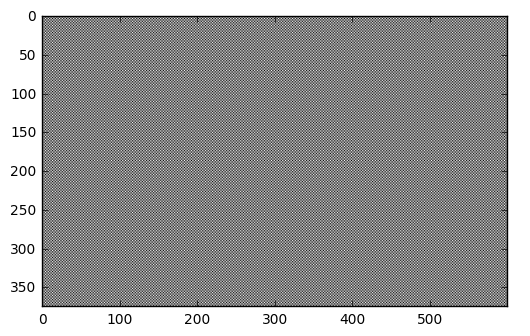

In [116]:
# now lets apply floyd steinberg dithering to it
floyd_steinberg_solid_gray = floyd_steinberg_dither(solid_gray_img)
plt.imshow(floyd_steinberg_solid_gray, cmap=plt.cm.gray)
plt.show()

As we can see here, when floyd steinberg is applied to a solid color image it yields a perfect checker pattern result. In this sense the error is completely evenly distributed both horizontally and vertically, yielding much cleaner results than the original algorithm.

In [74]:
0 + 5 * 6 / 16

1.875

In [75]:
6/16

0.375

In [76]:
5 * .375

1.875